# 03_deep_learning

## 3.1 Setup

In [82]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
from IPython.display import HTML

# Common imports
import numpy as np
import os
import tensorflow as tf

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import matplotlib.image as mpimg
def plot_external(img):
    img_name = os.path.join(".", "images",img)
    plots = mpimg.imread(img_name)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def plot_external2(imgpath):    
    plots = mpimg.imread(imgpath)
    plt.axis("off")
    plt.imshow(plots)    
    plt.show()
    
def mnist_load_data():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    
    return (X_train, y_train), (X_valid, y_valid), (X_test, y_test)

# progress bar
from tqdm import tqdm_notebook

고해상도 이미지에서 수백 가지 유형의 객체를 감지하는 것과 같이 매우 복잡한 문제를 해결해야하는 경우에는 아마도 수십만 개의 연결로 연결된 수백 개의 뉴런을 포함하고있는 10 개의 레이어를 가진 훨씬 더 깊은 DNN을 훈련해야 할 수도 있습니다. 이것은 쉬운 일이 아닙니다.

- 첫째, DNN에 영향을 미치고 하위 계층을 매우 힘들게 만드는 까다로운 "사라지는 그라디언트 문제"(또는 관련된 폭발 그라디언트 문제)에 직면하게됩니다.

- 두 번째로, 그러한 대규모 네트워크에서 학습은 매우 느릴 것입니다.

- 셋째, 수백만 개의 매개 변수가있는 학습은 훈련 세트에 과도한 영향을 미칠 수 있습니다.  

## 3.2 그래디언트 소실과 폭주 문제

역전파 알고리즘은 출력 레이어에서 입력 레이어로 이동하여 오차 그래디언트를 전파합니다. 알고리즘이 네트워크의 각 매개 변수와 관련하여 비용 함수의 그래디언트를 계산하면 경사 하강법 단계에서 각 매개 변수를 Gradient Descent 단계로 업데이트합니다.  

불행하게도, 그레디언트는 알고리즘이 하위 레이어로 진행함에 따라 종종 작아지고 작아집니다. 결국 경사 하강법이 하위층의 연결 가중치를 실제 변경되지 않은 채로 둔다면 훈련이 좋은 솔루션으로 수렴되지 않습니다. 이 문제를 **그래디언트 소실**이라고 합니다. 경우에 따라 그 반대가 발생할 수 있습니다. 즉, 그래디언트가 커질 수 있기 때문에 많은 레이어가 엄청나게 큰 가중치 업데이트를 가져오고 알고리즘이 발산하게 됩니다. 이 문제를 **그래디언트 폭주**라고 하며 순환 신경망에서 주로 나타납니다. 일반적으로 심층 신경망은 불안정한 그래디언트에 영향을 많이 받습니다. 여러 층이 서로 다른 속도로 학습될 수 있기 때문입니다.  

초기에는 로지스틱 시그모이드 활성화 함수와 그 당시 가장 인기 있었던 가중치 초기화 방법의 조합이 있었습니다. 즉, 평균 0과 표준 편차 1의 정규 분포를 사용한 무작위 초기화입니다. 즉,이 활성화 함수와이 초기화 방식을 사용하면 각 레이어의 출력의 분산이 입력의 분산보다 훨씬 큽니다. 신경망의 위쪽으로 갈수록 층을 지날 때마다 분산이 계속 커져 가장 높은 층에서는 활성화 함수가 0이나 1로 수렴합니다.이는 로지스틱 함수의 평균이 0이 아닌 0.5이기 때문에 더 나빠집니다.(쌍곡선 탄젠트 함수는 평균이 0이고 깊은 신경망에서의 로지스틱 함수보다 약간 더 낫습니다).

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

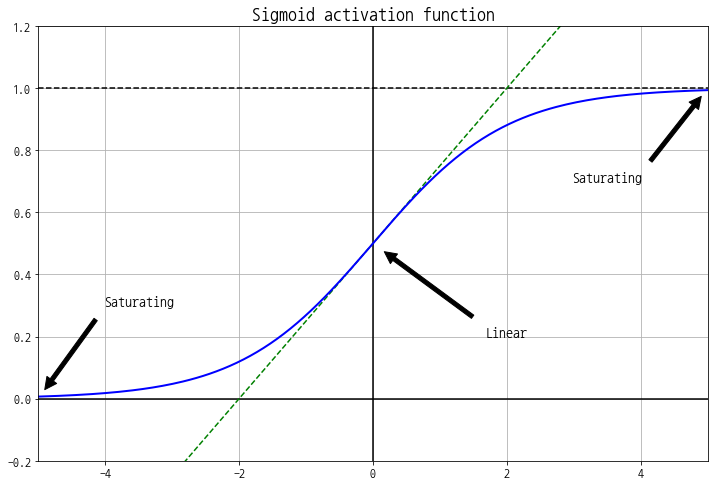

In [4]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(12, 8))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=18)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

로지스틱 활성화 함수를 보면 입력 값이 커지면 (음수 또는 양수) 함수가 0 또는 1로 수렴하고 매우 미분이 0에 가까워짐을 알 수 있습니다. 따라서 역전파가 시작될 때, 신경망 통해 다시 전파되는 그라디언트가 거의 없으며 상위 전파층을 통해 전파 전파가 진행됨에 따라 희석되는 희박한 그래디언트가 있으므로 하위층에는 아무 것도 남지 않았습니다.

### 3.2.1 세이비어 초기화와 He 초기화 

글로럿과 벤지오는 그들의 논문에서 이 문제를 크게 완화시키는 방법을 제안합니다. 예측을 할 때는 정방향으로, 그래디언트를 역전파할 때는 역방향으로 양방향 신호가 적헐하게 흘러야 합니다. 신호가 죽거나 폭주 또는 소멸하지 않아야 합니다. 그들은 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다고 주장합니다. 그리고 역방향에서 층을 통과하기 전과 후의 그래디언트 분산이 동일해야 합니다. 사실 층의 입력과 출력 연결 갯수가 같지 않다면 이 2가지를 보장할 수 없습니다. 하지만 그들은 실전에서 매우 잘 작동한다고 입증된 대안을 제안하였습니다. 연결 가중치 다음 식으로 무작위로 초기화하는 것입니다.  

**세이비어 초기화(로지스틱 활성화 함수를 사용했을 때)**
$$
평균이\; 0이고\; 표준편차\; \sigma=\sqrt{ \frac{2}{n_{inputs} + n_{outputs}} } \\
또는\; r=\sqrt{ \frac{6}{n_{inputs} + n_{outputs}} }일\; 때\; -r과\; +r\; 사이의\; 균등분포
$$  
입력의 연결 갯수가 대략 출력의 연결갯수와 비슷하면 더 간단한 공식을 사용합니다.  
($\sigma=1\diagup\sqrt{n_{inputs}}$또는 $r=\sqrt{3}\diagup\sqrt{n_{inputs}}$)  
세이비어 초기화 전략을 사용하면 훈련 속도를 상당히 높일 수 있습니다. 이 것이 현재 딥러닝의 성공을 견인한 기술 중 하나입니다. ReLU 활성화 함수를 위한 초기화 전략을 He 초기화라고 부릅니다.

In [4]:
import tensorflow as tf

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                          kernel_initializer=he_init, name="hidden1")

### 3.2.2 수렴하지 않는 활성화 함수

글로럿과 벤지오의 2010년 논문에서 얻은 통찰 중 하나는 활성화 함수를 잘못 선택하면 자칫 그래디언트의 소실이나 폭주로 이어질 수 있다는 것입니다. 그 전에는 대부분의 사람이 생물학전 뉴런의 방식과 비슷한 시그모이드 활성화 함수가 최선의 선택일 것이라고 생각했습니다. 하지만 다른 활성화 함수가 심층 신경망에서 훨씬 더 잘 작동한다는 사실이 밝혀졌습니다. 특히 ReLU함수는 특정 양숫값에 수렴하지 않는다는 커다란 장점이 있습니다.  

ReLU 함수는 완벽하지 않습니다. **dying ReLU**로 알려진 문제가 있습니다. 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다는 의미로 죽었다고 말합니다. 어떤 경우에는, 특히 큰 학습률을 사용하면 신경망의 뉴런 절반이 죽어 있기도 합니다. 훈련 도중 뉴런의 가중치가 바뀌어 가중치 합이 음수가 되면 그 다음부터 0을 출력하기 시작할 것입니다. ReLU함수는 입력이 음수면 그래디언트가 0이 되기 때문에 이런 일이 생기면 뉴런이 다시 살아나기 어렵습니다.  

이 문제를 해결하기 위해 **LeakyReLU** 같은 ReLU 함수의 변형을 사용하게 됩니다. 이 함수는 다음 식으로 표현됩니다.  
$$
    LeakyReLU_{\alpha}(z)=max(\alpha z,\, z)
$$
하이퍼파라미터 $\alpha$가 이 함수의 ***leaky***정도를 결정합니다. leaky 정도란 $z<0$일 때 이 함수의 기울기이며, 일반적으로 **0.01**로 설정합니다. 이 작은 기울기가 LeakyReLU를 절대 죽지 않게 만들어줍니다. 뉴런이 혼수상태에 오래 있을 수는 있지만 다시 깨어날 가능성을 얻게 됩니다. 최근 한 논문에서 여러 ReLU 함수의 변형을 비교해 얻은 결론 하나는 LeakyReLU가 ReLU보다 항상 성능이 높다는 것입니다. 사실 $\alpha=0.2$(많이 통과)로 하는 것이 $\alpha=0.01$(조금 통과)보다 더 나은 성능을 내는 것으로 보입니다. 이 논문은 훈련하는 동안 주이진 범위에서 $\alpha$를 무작위로 선택하고 테스트시에는 평균을 사용하는 **RReLU(Randomized Leaky ReLU)**도 평가했습니다. 이 함수도 꽤 잘 작동했으며(훈련 세트의 과대 적합 위험을 줄이는)규제의 역할을 하는 것처럼 보였습니다. 마지막으로 $\alpha$가 훈련하는 동안 학습되는 **Parametric Leaky ReLU**도 비교했습니다.(즉, 하이퍼파라미터가 아니고 다른 모델 파라미터와 마찬가지로 역전파에 의해 변경됩니다.)이 함수는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 크게 앞섰지만, 소규모 데이터셋에서는 훈련 세트에 과대적합될 위험이 있습니다.

In [6]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

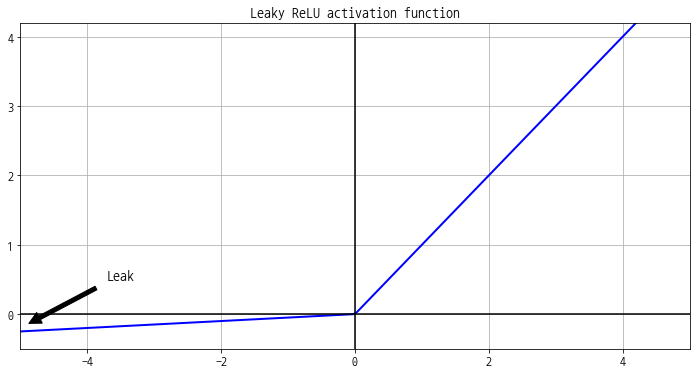

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

<br>
<br>

또 하나의 중요한 함수는 2015년의 한 논문에서 제안한 **ELU(Exponential Linear Unit)**라는 새로운 **활성화 함수**입니다. 이 함수는 실험에서 다른 모든 ReLU 변종의 성능을 앞질렀습니다. 훈련 시간이 줄고 신경망의 테스트 세트 성능도 더 높았습니다. 이 함수는 다음과 같이 표현됩니다.:  

$$
ELU_{\alpha}(z)=
\begin{cases}
\alpha(exp(z)-1) \qquad z<0\\
z \qquad \quad \quad \quad  \quad \; \,z \ge 0
\end{cases}
$$

In [9]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

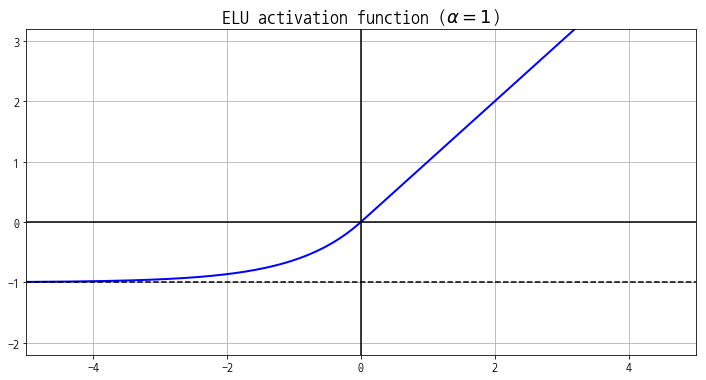

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=18)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

이 함수는 ReLU와 매우 비슷하지만 다음과 같은 차이점이 있습니다.  
- 1. $z < 0$일 때 음숫값이 들어오므로 활성화 함수의 평균 출력이 0에 더 가까워집니다. 이는 그래디언트 소실 문제를 완화해줍니다. 하이퍼파라미터 $\alpha$는 $z$가 큰 음숫값일 때 *ELU*가 수렴할 값을 정의합니다. 보통 1로 설정하지만 필요하면 다른 하이퍼파라미터처럼 원하는 값으로 변경할 수 있습니다.  

- 2. $z < 0$이어도 그래디언트가 0이 아니므로 죽은 뉴런을 만들지 않습니다.  

- 3. $\alpha=1$일 때 이 함수는 $z=0$에서 급격히 변동하지 않고 $z=0$을 포함해 모든 구간에서 매끄러워 경사하강법의 속도를 높여줍니다.  

ELU 활성화 함수의 주요 단점은 ReLU가 그 변종들보다(지수 함수를 사용하기 때문에) 계산이 느리다는 것입니다. 훈련하는 동안에는 수렴 속도가 빠르기 때문에 상쇄되지만 테스트 시에는 ELU신경망이 ReLU 신경망보다 느릴 것입니다.

심층 신경망의 은닉층에는 일반적으로 **ELU > LeakyReLU(etc...) > ReLU > tanh > Logistic** 순으로 사용하며 실행 속도가 중요하다면 LeakyReLU가 ELU보다 나을 수 있습니다. 하이퍼파라미터를 더 추가하고 싶지 않다면 앞서 추천한 기본 $\alpha$값을 사용합니다(LeakyReLU=0.01, ELU=1). 시간과 컴퓨팅 파워가 충분하다면 교차 검증을 사용해 여러 활성화 함수를 평가해볼 수 있습니다. 특히 신경망이 과대적합되었다면 RReLU, 훈련 세트가 아주 크다면 PReLU를 포함시키면 좋습니다.

<br>
<br>

SELU 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 논문에서 소개되었습니다. 훈련할 때 SELU 활성화 함수를 사용한 완전 연결 신경망은 스스로 정규화를 합니다. 각 층의 출력은 훈련하는 동안 같은 평균과 분산을 유지하려는 경향이 있어 그래디언트 소실과 폭주 문제를 해결합니다. 이 활성화 함수는 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다. 식은 다음과 같습니다.  
$$SELU(x) = \lambda 
\begin{cases}
x \qquad \qquad \qquad if\; x>0 \\
\alpha(e^{x}-1) \qquad \quad \,if\; x \le 0
\end{cases}
$$

In [11]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [12]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

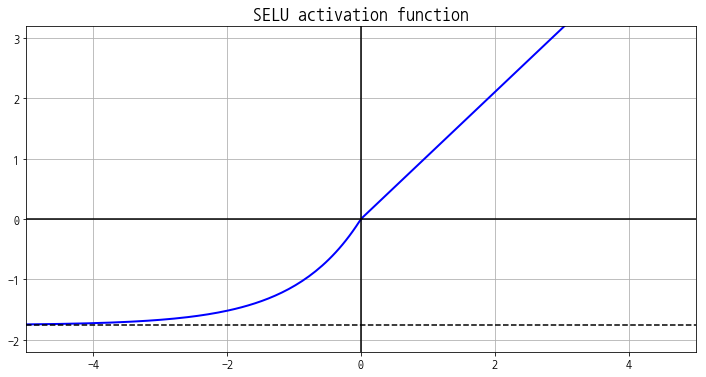

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=18)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

기본적으로 SELU 하이퍼파라미터(scale과 alpha)는 평균이 0, 표준 편차가 1에 가깝게 유지되도록 조정합니다(입력도 평균이 0, 표준 편차가 1로 표준화되었다고 가정합니다). 이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

In [17]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) 
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


SELU 활성화 함수를 사용한 신경망을 만들어 MNIST 문제를 풀어 보겠습니다:

In [25]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

이제 훈련할 차례입니다. 입력을 평균 0, 표준 편차 1로 스케일 조정해야 합니다:

In [26]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [27]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [28]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_valid)

    save_path = saver.save(sess, "./models/my_model_final_selu.ckpt")

0 배치 데이터 정확도: 0.92 검증 세트 정확도: 0.9194
5 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9548
10 배치 데이터 정확도: 0.98 검증 세트 정확도: 0.9638
15 배치 데이터 정확도: 0.96 검증 세트 정확도: 0.9674
20 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9682
25 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9686
30 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9712
35 배치 데이터 정확도: 1.0 검증 세트 정확도: 0.9718


### 3.2.3 배치 정규화
각 은닉층의 활성화 함수 전에 배치 정규화를 추가하기 위해 ELU 활성화 함수를 배치 정규화 층 이후에 수동으로 적용하겠습니다.

노트: `tf.layers.dense()` 함수가 `tf.contrib.layers.arg_scope()`와 호환되지 않기 때문에 대신 파이썬의 `functools.partial()` 함수를 사용합니다. 이를 사용해 `tf.layers.dense()`에 필요한 매개변수가 자동으로 설정되도록 `my_dense_layer()`를 만듭니다(그렇지 않으면 `my_dense_layer()`를 호출할 때마다 덮어씌여질 것입니다). 다른 코드는 이전과 비슷합니다.

ELU(또는 다른 ReLU 변종)와 함께 He 초기화를 사용하면 훈련 초기 단계에서 그래디언트 소실이나 폭주 문제를 크게 감소시킬 수 있지만, 훈련하는 동안 다시 발생하지 않으리란 보장은 없습니다.  

2015년 한 논문에서 세르게이 아이오페와 크리스티안 세게디가 그래디언트 소실과 폭주 문제를 해결하기 위한 **Batch Normalization**기법을 제안했습니다. 더 일반적으로는 훈련하는 동안 이전 층의 파라미터가 변함에 따라 각 층에 들어오는 입력의 분포가 변화되는 문제입니다(**Internal Covariate Shift**문제)  

이 기법은 각 층에서 활성화 함수를 통과하기 전에 모델에 연산을 하나 추가합니다. 단순하게 입력 데이터의 평균을 0으로 만들고 정규화한 다음, 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킵니다(하나는 스케일 조정을 위해, 다른 하나는 이동을 위해 필요합니다). 다시 말해 이 연산으로 모델이 층마다 입력 데이터의 최적 스케일과 평균을 학습합니다.

입력 데이터의 평균을 0으로 만들고 정규화하려면 알고리즘은 평균과 표준편차를 추정해야 합니다. 이를 위해 현재 미니배치에서 입력의 평균과 표준편차를 평가합니다(그래서 이름이 **배치정규화**)  

**배치 정규화 알고리즘**  
$$
\begin{split}
1. \quad \mu_{B} &= \frac{1}{m_{B}}\sum^{m_{B}}_{i=1}{(\mathbf{x})^{(i)}} \\
2. \quad \sigma^{2}_{B} &= \frac{1}{m_{B}}\sum^{m_{B}}_{i=1}{(\mathbf{x}^{(i)} - \mu_{B})}^{2}\\
3. \quad \hat{ \mathbf{x} }^{(i)} &= \frac{ \mathbf{x}^{(i)} - \mu_{B}}{ \sqrt{\sigma^{2}_{B} + \varepsilon} }\\
4. \quad \mathbf{z}^{(i)} &= \gamma\hat{ \mathbf{x} }^{(i)} + \beta
\end{split}
$$

- $\mu_{B}$는 미니배치 B에 대해 평가하여 관측한 평균  
- $\sigma_{B}$도 미니배치에 대해 평가하여 관측한 표준편차  
- $m_{B}$는 미니재치에 있는 샘플 수  
- $\hat{ \mathbf{x} }^{(i)}$은 평균이 0이고 정규화된 입력값  
- $\gamma$는 층의 스케일 파라미터  
- $\beta$는 층의 이동(편향)파라미터  
- $\varepsilon$은 분모가 0이 되는 것을 막기 위한 작은 숫자(전형적으로 $10^{-5}$)입니다. 이를 **smoothing term**(안전을 위한 항)  
- $\mathbf{z}^{(i)}$은 Batch Normal 연산의 출력. 즉 입력의 스케일을 조정하고 이동시킨 것

테스트할 때는 평균과 표준편차를 계산할 미니배치가 없으니 전체 훈련 세트의 평균과 표준편차를 대신 사용합니다. 이 값들은 훈련 과정에서 이동평균을 사용하여 효율적으로 계산되므로, 전체적으로 보면 배치 정규화된 층마다 $\gamma$(스케일), $\beta$(이동), $\mu$(평균), $\sigma$(표준편차) 네 개의 파라미터가 학습됩니다.  

이 기법으로 논문에서 실험했던 모든 심층 신경망의 성능이 크게 향상되었습니다. ***tanh***나 심지어 ***로지스틱 함수***같이 수렴되는 활성화 함수를 사용하더라도 그래디언트 소실 문제가 크게 감소되었습니다. 또한 네트워크가 가중치 초기화에 훨씬 덜 민감해집니다. 그리고 훨씬 큰 학습률을 사용할 수 있어 학습 속도를 크게 개선해줍니다. 특별히 이 논문에서 다음과 같이 언급되어 있습니다. ⌜가장 뛰어난 이미지 분류 모델에 적용하면 배치 정규화가 14배나 적은 훈련단계에서 같은 정확도를 달성하고 상당한 차이로 원래 모델을 앞지릅니다. 배치 정규화된 모델의 앙상블을 사용해 ImageNet 분류의 가장 뛰어난 수준에 도달했습니다.⌟마지막으로 배치 정규화는 규제와 같은 역할을 하여 드롭아웃 같은 규제 기법의 필요성을 줄여줍니다.  

그러나 (첫 번째 은닉층에 배치 정규화를 적용하면 입력 데이터를 정규화할 필요가 없어지지만) 배치 정규화는 모델의 복잡도를 키웁니다. 더군다나 실행 시간 면에서도 손해입니다. 층 마다 추가되는 계산이 신경망의 예측을 느려지게 합니다. 예측이 전광석화처럼 빨라야 한다면 배치 정규화를 사용하기 전에 ELU + He 초기화만으로 얼마나 잘 수행되는지 확인해보는 것이 좋습니다. 

*경사 하강법은 층마다 최적의 스케일과 이동을 위한 파라미터를 찾느라 훈련 초기에는 오히려 느려질 수 있습니다. 그러나 적절한 값을 찾고 나면 점점 빨라집니다.*

In [31]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

In [34]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

```python
training = tf.placeholder_with_default(False, shape=(), name='training')
```
training은 훈련하는 동안에는 **True**로 그 외에는 **False**로 설정합니다. 이를 이용하여  
```python
tf.layers.batch_normalization()
```
훈련할 때: 현재 미니배치의 평균과 표준편차를 사용할지  
테스트할 때: 전체 훈련 세트에 대한 평균과 표준편차를 사용할지를 결정

같은 매개변수를 계속 반복해서 쓰지 않도록 파이썬의 `partial()` 함수를 사용합니다:

In [35]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization,
                              training=training, momentum=0.9)

Batch Normalization은 **exponential decay**를 사용해 이동평균을 계산합니다. 새로운 값 $v$가 주어지면 이동평균$\hat{v}$은 다음 식을 통해 갱신됩니다.  

$$\hat{v} \leftarrow \hat{v} \,\times\,momentum + v\,\times\,(1-momentum)$$  
적절한 모멘텀 값은 일반적으로 1에 가깝습니다. 데이터셋이 크고 미니배치가 작을 경우 1에 가깝게 합니다.

In [36]:
hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)

Instructions for updating:
Use keras.layers.batch_normalization instead.


각 층에 ELU 활성화 함수와 배치 정규화를 사용하여 MNIST를 위한 신경망을 만듭니다:

In [37]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name='training')

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()

    my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training=training,
            momentum=batch_norm_momentum)

    my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.cast instead.


노트: 배치 정규화를 위해 별도의 업데이트 연산을 실행해 주어야 합니다(`sess.run([training_op, extra_update_ops],...`).

```python
batch_normalization()
```
의존하는 어떤 연산을 수행할 때마다 training 플레이스홀더를 True로 설정해야 합니다. `batch_normalization()`함수는 이동 평균을 갱신하기 위해 매 훈련 단계에서 평가할 때 몇 개의 연산을 만듭니다.(이 이동 평균이 훈련 세트의 평균과 표준편차를 계산하기 위해 필요합니다.)이 연산은 자동으로 `UPDATE_OPS`컬렉션에 추가되므로 이 컬렉션에서 연산들을 뽑아내어 훈련이 반복될 때마다 실행해주면 됩니다.

In [39]:
n_epochs = 20
batch_size = 200

In [40]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops],
                     feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./models/03_deep_learning/my_model_final.ckpt")

0 검증 세트 정확도: 0.8952
1 검증 세트 정확도: 0.9202
2 검증 세트 정확도: 0.9318
3 검증 세트 정확도: 0.9422
4 검증 세트 정확도: 0.9468
5 검증 세트 정확도: 0.954
6 검증 세트 정확도: 0.9568
7 검증 세트 정확도: 0.96
8 검증 세트 정확도: 0.962
9 검증 세트 정확도: 0.9638
10 검증 세트 정확도: 0.9662
11 검증 세트 정확도: 0.9682
12 검증 세트 정확도: 0.9672
13 검증 세트 정확도: 0.9696
14 검증 세트 정확도: 0.9706
15 검증 세트 정확도: 0.9704
16 검증 세트 정확도: 0.9718
17 검증 세트 정확도: 0.9726
18 검증 세트 정확도: 0.9738
19 검증 세트 정확도: 0.9742


훈련을 더 오래하면 정확도가 높아지겠지만 이런 얕은 신경망에서는 배치 정규화와 ELU가 큰 효과를 내지 못합니다. 대부분 심층 신경망에서 빛을 발합니다.

업데이트 연산에 의존하는 훈련 연산을 만들 수도 있습니다:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

이렇게 하면 훈련할 때 `training_op`만 평가하면 텐서플로가 업데이트 연산도 자동으로 실행할 것입니다:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

한가지 더, 훈련될 변수 개수가 전체 전역 변수 개수보다 적습니다. 이동 평균을 위한 변수는 훈련되는 변수가 아니기 때문입니다. 미리 학습한 신경망을 재사용할 경우(아래 참조) 이런 훈련되지 않는 변수를 놓쳐서는 안됩니다.

In [41]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [42]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### 3.2.4 그래디언트 클리핑

그래디언트 폭주 문제를 줄이는 쉬운 방법은 역전파될 때 일정 임곗값을 넘어서지 못하게 그래디언트를 단순히 잘라내는 것입니다.(순환 신경망에서 일반적으로 널리 사용됩니다.) 이를 그래디언트 클리핑(Gradient Clipping)이라고 합니다. 일반적으로 배치 정규화를 선호합니다.  

텐서플로에서 옵티마이저의 `minimize()`함수는 그래디언트의 계산과 적용 두 가지를 모두 처리합니다.그래서 이 함수를 대신하려면 옵티마이저의 `compute_gradients()`메서드를 먼저 호출하고, 그 다음에 `clip_by_value()` 함수를 사용해 그래디언트를 클리핑하는 연산을 생성합니다. 마지막으로 옵티마이저의 `apply_gradients()`메서드를 사용해 클리핑된 그래디언트를 적용하는 연산을 만듭니다. 

MNIST를 위한 간단한 신경망을 만들고 그래디언트 클리핑을 적용해 보겠습니다. 

In [44]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = mnist_load_data()

In [45]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [46]:
learning_rate = 0.01

이제 그래디언트 클리핑을 적용합니다. 먼저 그래디언트를 구한 다음 `clip_by_value()` 함수를 사용해 클리핑하고 적용합니다:

In [49]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [50]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [51]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
n_epochs = 20
batch_size = 200

In [53]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "검증 세트 정확도:", accuracy_val)

    save_path = saver.save(sess, "./models/clipping/my_model_final.ckpt")

0 검증 세트 정확도: 0.288
1 검증 세트 정확도: 0.794
2 검증 세트 정확도: 0.8796
3 검증 세트 정확도: 0.906
4 검증 세트 정확도: 0.9164
5 검증 세트 정확도: 0.922
6 검증 세트 정확도: 0.9294
7 검증 세트 정확도: 0.9358
8 검증 세트 정확도: 0.938
9 검증 세트 정확도: 0.9416
10 검증 세트 정확도: 0.9456
11 검증 세트 정확도: 0.9472
12 검증 세트 정확도: 0.9476
13 검증 세트 정확도: 0.9534
14 검증 세트 정확도: 0.9566
15 검증 세트 정확도: 0.9566
16 검증 세트 정확도: 0.9578
17 검증 세트 정확도: 0.9588
18 검증 세트 정확도: 0.9624
19 검증 세트 정확도: 0.9616


## 3.3 미리 훈련된 층 재사용하기

일반적으로 아주 큰 규모의 DNN을 처음부터 새로 훈련시키는 것은 좋은 생각이 아닙니다. 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아보고 그런 다음 그 신경망의 하위층을 재사용하는 것이 좋습니다. 이를 **transfer learning**이라고 합니다. 이 방법은 훈련속도를 크게 높여줄 뿐만 아니라 필요한 훈련 데이터도 훨씬 적습니다.  

예를 들어 동물, 식물, 자동차, 생활용품을 포함하여 100개의 카테고리로 구분된 이미지를 분류하도록 훈련시킨 DNN을 가지고 있다고 가정합시다. 그리고 이제 구체적인 자동차의 종류를 분류하는 DNN을 훈련시키려 합니다. 이런 작업들은 비슷한 점이 많으므로 첫 번째 신경망의 일부를 재사용해봐야 합니다. 

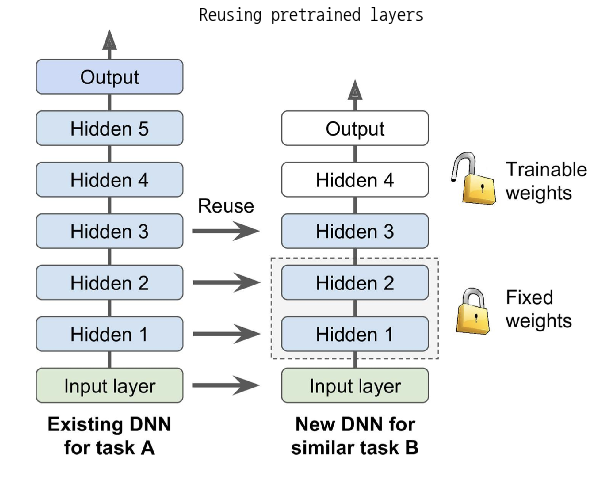

In [54]:
plt.figure(figsize=(12, 8))
plt.title("Reusing pretrained layers", fontsize=18)
plot_external("07.png")

> 만약 원래 문제에서 사용한 것과 크기가 다른 이미지를 입력으로 사용한다면 원본 모델이 맞는 크기로 변경하는 전처리 단계를 추가해야 합니다. 일반적으로 transfer learning은 입력이 비슷한 저수준 특성을 가질 때 잘 작동합니다. 

<br>
<br>

## 3.3 고속 옵티마이저

아주 큰 심층 신경망은 훈련이 심각하게 느릴 수 있습니다. 연결 가중치에 좋은 초기화 전략 적용하기, 좋은 활서화 함수 사용하기, 배치 정규화 사용하기 등 입니다. 훈련 속도를 크게 높일 수 있는 또 다른 방법으로 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수 있습니다. **Momentum Optimization, Nesterov Accelerated Gradient, AdaGrad, RMSProp, Adam optimizer** 가 가장 많이 사용됩니다.

### 3.3.1 Momentum Optimization

볼링공이 매끈한 표면의 완만한 경사를 따라 굴러간다고 하면 처음에는 느리게 출발하지만 terminal velocity에 도달할 때까지는 빠르게 가속될 것입니다. 이것이 보리스 폴락(Boris Polyak)이 1964년에 제안한 **Momentum Optimization**의 간단한 원리 입니다. 반대로 표준적인 경사 하강법은 경사면을 따라 일정한 크기의 스텝으로 조금씩 내려갑니다. 그래서 맨 아래에 도착하는데 시간이 더 오래 걸릴 것입니다.  

경사 하강법은 가중치에 대한 비용 함수 $J(\theta)$의 그래디언트 ($\triangledown_{theta}J(\theta)$)에 학습률 $\eta$를 곱한 것을 바로 차감하여 가중치 $\theta$를 갱신합니다. 공식은:  
$$
\theta \;\leftarrow\;\theta\,-\,\eta\triangledown_{\theta}J(\theta)
$$
입니다. 이 식은 이전 그래디언트가 얼마였는지 고려하지 않습니다. 국부적으로 그래디언트가 아주 작으면 매우 느려질 것입니다.  

Momentum Optimization는 이전 그래디언트가 얼마였는지를 상당히 중요하게 생각합니다. 매 반복에서 현재 그래디언트를(학습률 $\eta$를 곱한 후) **momentum vector** **m**에 더하고 이 값을 빼는 방식으로 가중치를 갱신합니다. 수식적으로는 다음과 같습니다:  

$$
\begin{split}
&1. \quad\mathbf{m} \;\leftarrow\; \beta\mathbf{m} \,+\, \eta\triangledown_{\theta}J(\theta) \\
&2. \quad\theta \;\leftarrow\;\theta\,-\,\mathbf{m}
\end{split}
$$

다시 말해 그래디언트를 속도가 아니라 가속도로 사용합니다. 일종의 마찰저항을 표현하고 모멘텀이 너무 커지는 것을 막기 위해 이 알고리즘에는 **momentum(모멘텀)**이라는 새로운 하이퍼파라미터 $\beta$가 등장합니다. 이 값은 0(높은 마찰저항), 1(마찰저항 없음) 사이로 설정되어야 합니다. 일반적인 모멘텀 값은 0.9입니다.  

그래디언트가 일정하다면 ***terminal velocity***(즉, 가중치를 갱신하는 최대 크기)는 학습률 $\eta$를 곱한 그래디언트에 $\frac{1}{1-\beta}$을 곱한 것과 같음을 확인할 수 있습니다.  

예를 들어 $\beta=0.9$면 ***terminal velocity***는 그래디언트와 학습률을 곱하고 다시 10을 곱한 것과 같으므로 **모멘텀 최적화**가 경사 하강법보다 10배 빠르게 진행됩니다. 이는 모멘텀 최적화가 경사 하강법보다 더 빠르게 평편한 지역을 탈출하게 도와줍니다. 특히 입력값의 스케일이 매우 다르면 비용 함수는 한쪽이 길쭉해집니다.

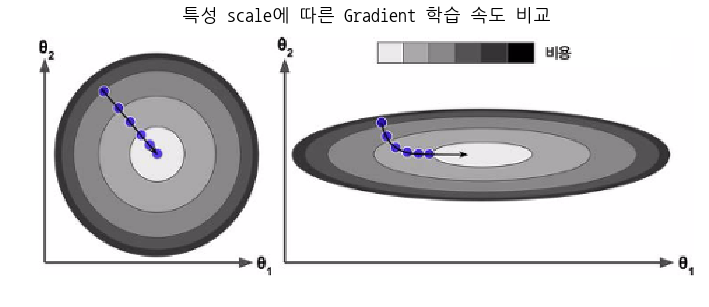

In [85]:
plt.figure(figsize=(12, 8))
plt.title("특성 scale에 따른 Gradient 학습 속도 비교", fontsize=18)
plot_external2("../sklearn/images/feature_scale.png")

경사 하강법이 가파른 경사를 꽤 빠르게 내려가지만 좁고 긴 골짜기에는 오랜 시간이 걸립니다. 반면에 **모멘텀 최적화**는 골짜기를 따라 바닥(최적점)에 도달할 때까지 점점 더 빠르게 내려갑니다. 배치 정규화를 사용하지 않는 심층 신경망에서 상위층은 종종 스케일이 매우 다른 입력을 받게 됩니다. 모멘텀 최적화를 사용하면 이런 경우 큰 도움이 됩니다. 또한 이 기법은 **local optima**을 건너뛰도록 하는 데도 도움이 됩니다.  

> **모멘텀** 때문에 옵티마이저가 최적값에 안정되기 전까지 건너뛰었다가 다시 돌아오고, 다시 또 건너 뛰는 식으로 여러 번 왔다 갔다 할 수 있습니다. 이 것이 시스템에 마찰저항이 조금 있는 것이 좋은 이유입니다. 이런 진동을 없애주고 빠르게 수렴되도록 합니다.

```python
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
```

<br>
<br>

### 3.3.2 Nesterov Accelerated Gradient

**네스테로프 모멘텀 최적화(Nesterov Momentum Optimization)**, **네스테로프 가속 경사(Nesterov Accelerated Gradient, NAG)**는 1983년 유리 네스테로프(Yuri Nesterov)가 제안한 모멘텀 최적화의 한 변형입니다. 기본 모멘텀 최적화보다 거의 항상 빠릅니다.  

기본 아이디어는 현재 위치가 아니라 모멘텀의 방향으로 조금 앞서서 비용 함수의 그래디언트를 계산하는 것입니다. 수식으로는 다음과 같습니다.  

$$
\begin{split}
&1. \quad\mathbf{m} \;\leftarrow\; \beta\mathbf{m} \,+\, \eta\triangledown_{\theta}J(\theta\,-\,\beta\mathbf{m}) \\
&2. \quad\theta \;\leftarrow\;\theta\,-\,\mathbf{m}
\end{split}
$$

일반적으로 모멘텀 벡터가 올바른 방향(즉, 최적점을 향하는 방향)을 가리킬 것이므로 이런 변경이 가능합니다. 

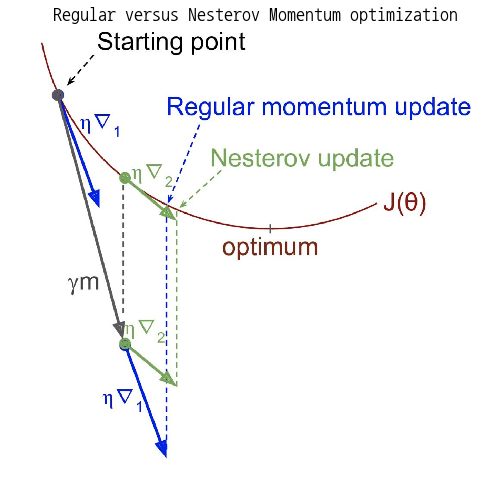

In [84]:
plt.figure(figsize=(12, 8))
plt.title("Regular versus Nesterov Momentum optimization", fontsize=18)
plot_external2("./images/08.png")

그래서  위 그림 처럼 원래 위치에서 그래디언트를 사용하는 것보다 그 방향으로 조금 더 나아가서 측정한 그래디언트를 사용하는 것이 약간 더 정확할 것입니다. ( $\triangledown_{1}$은 시작점 $\theta$에서 측정한 비용 함수의 그래디언트를 나타내고, $\triangledown_{2}$는 $\theta\,-\,\beta\mathbf{m}$에서 측정한 그래디언트를 나타냄) 여기서 볼 수 있듯이 네스테로프 업데이트가 최적값에 조금 더 가깝습니다. 시간이 조금 지나면 이 이 작은 차이가 쌓여서 **NAG**가 기본 모멘텀 최적화보다 확연히 빨라지게 됩니다. 더군다나 모멘텀이 골짜기를 가로지르도록 가중치에 힘을 가할 때 $\triangledown_{1}$은 골짜기를 더 가로지르도록 하지만 $\triangledown_{2}$는 계곡의 아래쪽으로 잡아당기게 됩니다. 이는 진동을 감소시키고 수렴을 빠르게 만들어줍니다.  

**NAG**가 기본 모멘텀 최적화보다 거의 항상 훈련 속도를 높여줍니다. 이를 사용하려면 `optimzer`부분을 다음과 같이 작성하면 됩니다. 

```python
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=0.9, use_nesterov=True)
```

### 3.3.3 AdaGrad

한쪽이 길쭉한 그릇 문제를 다시 생각해보면 경사하강법은 가장 가파른 경사를 따라 빠르게 내려가기 시작해서 골짜기 아래로 느리게 이동합니다. AdaGrad 알고리즘은 가장 가프란차원을 따라 그래디언트 벡터의 스케일을 감소시켜 이 문제를 해결합니다.  
수식은 다음과 같습니다.  

$$
\begin{split}
&1. \;\mathbf{s} \,\leftarrow\, \mathbf{s}\,+\,\triangledown_{\theta}J(\theta) \,\otimes\, \triangledown_{\theta}J(\theta) \\
&2. \;\theta \,\leftarrow\,\theta \,-\,\eta\triangledown_{\theta}J(\theta)\,\oslash\,\sqrt{\mathbf{s}\,+\,\varepsilon} 
\end{split}
$$

첫 번째 단계는 그래디언트의 제곱을 벡터 $\mathbf{s}$에 누적합니다. $\otimes$은 원소별 곱셈을 나타냅니다. 이 벡터 형식의 계산은 벡터 $\mathbf{s}$의 각 원소 $s_{i}$마다  
$$
    s_{i} \;\leftarrow\; s_{i}\,+\, \left(\frac{ \partial J(\theta) }{ \partial\theta_{i} }\right)^{2}
$$
을 계산하는 것과 동일합니다. 다시 $s_{i}$는 파라미터 $\theta_{i}$에 대한 비용 함수의 편미분을 제곱하여 누적합니다. 비용 함수가 $i$번째 차원을 따라 가파르다면 $s_{i}$는 반복이 진행됨에 따라 점점 커질 것입니다.  

두번째 단계는 경사 하강법과 거의 같습니다. 한 가지 큰 차이는 그래디언트 벡터를 $\sqrt{\mathbf{s} + \varepsilon}$으로 나누어 스케일을 조정하는 점입니다.($\oslash$기호는 원소별 나눗셈을 나타내고 $\varepsilon$은 0으로 나누는 것을 막기 위한 값으로, 일반적으로 $10^{-10}$입니다.) 이 벡터 형식의 계산은 모든 파라미터 $\theta_{i}$에 대해 (동시에) 
$$
    \theta_{i} \;\leftarrow\; \theta_{i}\,-\,\eta\frac{ \partial J(\theta) }{ \partial\theta_{i} }\cdot \frac{1}{\sqrt{ s_{i} \,+\,\varepsilon }}
$$을 계산하는 것과 동일합니다.  

요약하면 이 알고리즘은 학습률($\mathbf{\eta}$)을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소됩니다. 이를 **Adaptive Learning Rate(적응적 학습률)**이라고 부르며, 전역 최적점 방향으로 더 곧장 가도록 갱신되는데 도움이 됩니다. 학습률 하이퍼파라미터 $\mathbf{\eta}$를 덜 튜닝해도 되는 점이 또하나의 장점입니다. 

```python
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
```

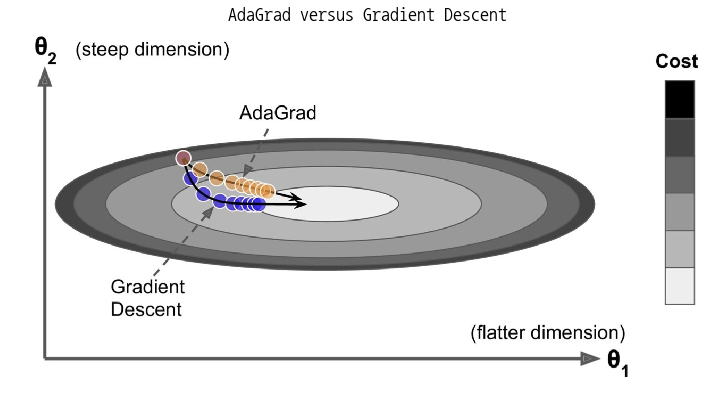

In [86]:
plt.figure(figsize=(12, 8))
plt.title("AdaGrad versus Gradient Descent", fontsize=18)
plot_external2("./images/09.png")

> AdaGrad는 간단한 2차방정식 문제에 대해서는 잘 작동하지만 신경망을 훈련시킬 때 너무 일찍 멈춰버리는 경향이 있습니다. 학습률이 너무 감소되어 전역 최솟점에 도착하기전에 알고리즘이 완전히 멈춥니다. 그래서 텐서플로에 AdagradOptimizer()가 있지만 심층 신경망에는 사용하지 말아야 합니다.(선형 회귀 같은 간단한 작업에는 효과적일 수 있습니다.)

<br>
<br>

### 3.3.4 RMSProp

AdaGrad는 너무 빠르게 느려져서 전역 최적점에 수렴하지 못하지만 **RMSProp**알고리즘은 (훈련 시작부터의 모든 그래디언트가 아니고) 가장 최근 반복에서 비롯된 그래디언트만 누적함으로써 이 문제를 해결했습니다. 이렇게 하기 위해 알고리즘의 첫 번째 단계에서 지수 감소를 사용합니다. 과정은 다음 식으로 표현됩니다.

$$\begin{split}  
&1.\; \mathbf{s}\, \leftarrow \, \beta\mathbf{s}\, + \left(1-\beta \right)\triangledown _{ \theta  }J(\theta )\, \otimes \, \triangledown _{ \theta  }J(\theta ) \\  
&2.\; \theta \, \leftarrow \, \theta \, -\, \eta \triangledown _{ \theta  }J(\theta )\, \oslash \, \sqrt { \mathbf{ s }\, +\, \varepsilon  }  \end{split}$$

보통 감쇠율 $\beta$는 0.9로 설정합니다.코드는 다음과 같이 작성합니다.  

```python
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, decay=0.9, epsilon=1e-10)
```

아주 간단한 문제를 제외하고는 이 옵티마이저가 AdaGrad보다 훨씬 더 성능이 좋습니다. 또 일반적으로 모멘텀 최적화나 네스테로프 가속 경사보다 더 빠르게 수렴합니다. 이 알고리즘은 Adam 최적화가 나오기 전까지 가장 선호하는 최적화 알고리즘이었습니다.

<br><br>

### 3.3.5 Adam optimizer

**Adaptive Moment Estimation, 적응적 모멘트 추정**을 의미하는 **Adam**은 **모멘텀 최적화**와 **RMSProp**의 아이디어를 합친 것입니다. 모멘텀 최적화처럼 지난 그래디언트의 **exponential decaying average, 지수 감소 평균**을 따르고 RMSProp처럼 지난 그래디언트 제곱의 지수 감소된 평균을 따릅니다. 과정은 다음 식으로 표현됩니다.  

$$\begin{split}
&1.\;\mathbf{m} \,\leftarrow\, \beta_{1}\mathbf{m}  \,+\, (1-\beta_{1})\triangledown_{\theta}J(\theta) \\
&2.\;\mathbf{s} \,\leftarrow\, \beta_{2}\mathbf{s} \,+\,(1-\beta_{2})\triangledown_{\theta}J(\theta)\,\otimes\,\triangledown_{\theta}J(\theta) \\
&3.\;\hat{\mathbf{m}} \,\leftarrow\, \frac{ \mathbf{m} }{{1-\beta_{1}}^{T}} \\
&4.\;\hat{\mathbf{s}} \,\leftarrow\, \frac{\mathbf{s}}{{1-\beta_{2}}^{T}} \\
&5.\;\theta \,\leftarrow\,\theta \,-\, \eta\hat{\mathbf{m}}\oslash\sqrt{\hat{\mathbf{s}}+\varepsilon}
\end{split}$$  

- $T$는 1부터 시작하는 반복횟수  

- 1, 2, 5 단계를 보면 Adam이 모멘텀 최적화, RMSProp와 아주 비슷하다는 것을 알 수 있습니다. 차이 나는 점은 단계 1에서 진수 감소 합 대신 지수 감소 평균을 계산하는 것이지만 이들은 상수 배인 것을 제외하면 동일함(지수 감소 평균은 지수 감소 합의 $1\,-\,\beta_{1}$배)  
- 3, 4 단계는 기술적으로 $\mathbf{m}$과 $\mathbf{s}$가 0으로 초기화되기 때문에 훈련 초기에 0쪽으로 치우치게 됩니다. 그래서 이 두 단계가 훈련 초기에 $\mathbf{m}$과 $\mathbf{s}$의 값을 증폭시키는데 도움이 됩니다.  

모멘텀 감쇠 하이퍼파라미터 $\mathbf{\beta_{1}}$은 보통 **0.9**로 초기화하고 스케일 감쇠 하이퍼파라미터 $\mathbf{\beta_{2}}$는 **0.999**로 초기화하는 경우가 많습니다. 안정된 계산을 위해 $\mathbf{\varepsilon}$은 보통 <b>$10^{-8}$</b>같은 난수로 초기화합니다. 이 값든은 텐서플로의 AdamOptimizer()로 구현되어 있습니다.  
코드는 다음과 같이 작성합니다. 

```python
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
```

**Adam**이 (**AdaGrad**나 **RMSProp**처러) 적응적 학습률 알고리즘이기 때문에 학습률 하이퍼 파라미터($\mathbf{\eta}$)를 튜닝할 필요가 적습니다. 기본값 $\mathbf{\eta}=0.001$을 일반적으로 사용하므로 경사하강법보다 **Adam**이 사용하기 쉽습니다.

지금까지 논의한 모든 최적화 기법은 **1차 편미분(야코비안, Jacobian)**에만 의존합니다. 최적화 이론에는 **2차편미분(헤시안, Hessian)**을 기반으로 한 뛰어난 알고리즘들이 있습니다. 이는 하나의 출력마다 $n$개의 1차 편미분이 아니라 $n^{2}$개의 2차 편미분을 계산해야 하기 때문에 심층 신경망에 적용하기 매우 어려습니다. DNN은 전형적으로 수만 개의 파라미터를 가지기 때문에 2차 편미분 초